In [80]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '651f2ed5-6e2f-41d0-b533-0cd28801ef2a'
resource_group = 'data'
workspace_name = 'data-workspace05a7960'

workspace = Workspace(subscription_id, resource_group, workspace_name)


In [100]:
## get new outcomes
def get_benefit_outcome_rates(offers_summary, accepts_summary,benefits):

    individual_outcome_rates = np.nan_to_num(accepts_summary/offers_summary)
    benefit_outcome_rates = (individual_outcome_rates*benefits)/sum(individual_outcome_rates*benefits)

    return benefit_outcome_rates

## update distribution
def update_distribution(benefit_outcome_rates, prior_distribution, confidence):
    relative_distribution_difference = np.nan_to_num((benefit_outcome_rates - prior_distribution)/prior_distribution*confidence)

    new_distribution = prior_distribution*(1+0.5*relative_distribution_difference)

    new_distribution = new_distribution/sum(new_distribution)
    return new_distribution

## get confidence measure
def get_confidence(offers_summary):

    confidence = offers_summary/sum(offers_summary)*50

    return confidence

## Create toy_data
def simulate_customers(N_customers, parameters_vector, distribution_vector, segments):
    customer_array = np.zeros([N_customers,7], dtype=object)
    for customer in range(N_customers):
        customer_parameters = np.random.choice(parameters_vector, p = distribution_vector).split('_')
        customer_array[customer,0] = customer
        customer_array[customer,1] = np.random.choice(segments)
        customer_array[customer,2] = customer_parameters[0]
        customer_array[customer,3] = customer_parameters[1]
        customer_array[customer,4] = customer_parameters[2]
        customer_array[customer,5] = np.random.choice([0,1], p = [0.7, 0.3])
        customer_array[customer,6] = np.random.randint(30,150)*customer_array[customer,5]

    return customer_array

## confidence function

def confidence(vector):
    confidence_value = np.zeros(len(vector))

    for x in range(len(vector)):
        confidence_value[x] = 1.0/(1.0 + math.exp(-0.5*(vector[x]-25.0)))

    return confidence_value

In [14]:
## Set up experiement

T = 2
N_offers = 5
Initial_offer = 2
segments = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC']

In [54]:
### Create initial distribution
parameter_1_list = [1,2,3,4,5]
parameter_2_list = [0,1,2]
parameter_3_list = [40,50,60,70,80] 
parameter_1_p = [0.2,0.2,0.2,0.2,0.2]
parameter_2_p = [0.1,0.1,0.8]
parameter_3_p = [0.2,0.2,0.2,0.2,0.2] 
sep = "_" 

distribution_matrix = np.zeros([len(parameter_1_list), len(parameter_2_list), len(parameter_3_list)])
parameters_matrix = np.zeros([len(parameter_1_list), len(parameter_2_list), len(parameter_3_list)], dtype=object)

for i in range(len(parameter_1_list)):
    for j in range(len(parameter_2_list)):
        for k in range(len(parameter_3_list)):
             distribution_matrix[i,j,k] = parameter_1_p[i]*parameter_2_p[j]*parameter_3_p[k]
             parameters_matrix[i,j,k] = sep.join([str(parameter_1_list[i]),str(parameter_2_list[j]),str(parameter_3_list[k])])

distribution_vector = distribution_matrix.flatten(order = "A")
parameters_vector = parameters_matrix.flatten(order = "A")

In [75]:
### CREATE TOY DATA
N_customers = 100000
customer_array = simulate_customers(N_customers, parameters_vector, distribution_vector, segments)

In [66]:
outcome_events = pd.DataFrame({'ID': customer_array[:, 0], 'Segment': customer_array[:, 1], 'Parameter_1': customer_array[:, 2], 'Parameter_2': customer_array[:, 3], 'Parameter_3': customer_array[:, 4], 'Bought': customer_array[:, 5], 'Basket_value': customer_array[:, 6]})
outcome_events = outcome_events.set_index('ID')
## Process outcomes
outcome_events['Parameter_mix'] = outcome_events[['Parameter_1', 'Parameter_2', 'Parameter_3']].agg('_'.join, axis=1)
number_of_offers = pd.pivot_table(outcome_events, index = 'Segment', columns = 'Parameter_mix', values = 'Bought', aggfunc='count').fillna(0)
number_of_accepts = pd.pivot_table(outcome_events, index = 'Segment', columns = 'Parameter_mix', values = 'Bought', aggfunc=np.sum).fillna(0)
benefits = pd.pivot_table(outcome_events[outcome_events['Bought'] == 1], index = 'Segment', columns = 'Parameter_mix', values = 'Basket_value', aggfunc=np.sum)/pd.pivot_table(outcome_events[outcome_events['Bought'] == 1], index = 'Segment', columns = 'Parameter_mix', values = 'Bought', aggfunc=np.sum)
benefits = benefits.fillna(0)

distributions = np.zeros([len(segments),T,outcome_events.Parameter_mix.nunique()])


In [45]:
outcome_events.Parameter_mix.nunique()

22

In [101]:
count = 0

for segment in segments:

    # GET NUMBER OF OFFERS AND ACCEPTS FROM OUTCOMES

    offers_summary = np.array(number_of_offers.loc[segment])
    accepts_summary = np.array(number_of_accepts.loc[segment])
    segment_benefits = np.array(benefits.loc[segment])
    
    distributions[count,0] = offers_summary/sum(offers_summary)

    ## WE ESTIMATE HOW CONFIDENT WE ARE IN EACH OUTCOME BEING SIGNIFICANT
    confidence = get_confidence(offers_summary)

    ## WE GET BENEFIT WAITED CLICK RATES OF EACH OFFER
    benefit_outcome_rates = get_benefit_outcome_rates(offers_summary, accepts_summary,segment_benefits)
    
    ## WE UPDATE THE PREVIOUS DISTRIBUTION BASED ON THE EVENTS WE HAVE SEEN
    distributions[count,1] = update_distribution(benefit_outcome_rates, distributions[count,0], confidence)


    count = count+1


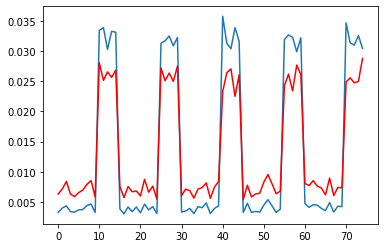

In [102]:
plt.plot(distributions[1,0])
plt.plot(distributions[1,1],'r')
plt.show()

In [96]:
confidence(offers_summary)

0
53
1
77
2
58
3
65
4
63
5
89
6
60
7
96
8
56
9
61
10
568
11
530
12
573
13
478
14
551
15
67
16
59
17
75
18
56
19
65
20
72
21
70
22
56
23
68
24
59
25
497
26
528
27
559
28
556
29
503
30
62
31
77
32
73
33
81
34
56
35
71
36
59
37
64
38
66
39
69
40
566
41
522
42
566
43
544
44
550
45
75
46
86
47
52
48
69
49
77
50
82
51
52
52
70
53
74
54
71
55
561
56
583
57
508
58
573
59
507
60
54
61
79
62
64
63
68
64
79
65
71
66
80
67
71
68
75
69
71
70
541
71
517
72
521
73
560
74
497


array([0.99999917, 1.        , 0.99999993, 1.        , 0.99999999,
       1.        , 0.99999997, 1.        , 0.99999981, 0.99999998,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999996, 1.        , 0.99999981, 1.        ,
       1.        , 1.        , 0.99999981, 1.        , 0.99999996,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999999, 1.        , 1.        , 1.        , 0.99999981,
       1.        , 0.99999996, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999863, 1.        , 1.        ,
       1.        , 0.99999863, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9999995 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     